# 🍫 ChocoChemist: Decoding Chocolate Quality with LightGBM

### 📝 Introduction

This project aims to predict the rating of chocolates based on various features like ingredients, manufacturer, origin, and taste descriptions. The goal is to explore how narrative text and product features influence chocolate quality as perceived by tasters.

### 🎯 Objective

- Predict chocolate ratings (on a scale of 1 to 4).
- Analyze and visualize important product and text-based features.
- Improve model accuracy using feature engineering and TF-IDF.


In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import mean_squared_error
import lightgbm as lgb
from lightgbm import LGBMRegressor
from scipy.sparse import hstack
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [3]:
# Load dataset
df = pd.read_csv('/content/choco.csv')

## 📂 Dataset Overview

- Rows: 2789 chocolate reviews
- Key columns:
  - `Company`, `Location`, `Country of Bean Origin`, `Review Date`
  - `Cocoa Percent`, `Ingredients`
  - `Most Memorable Characteristics` (free text)
  - `Rating` (target)


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2789 entries, 0 to 2788
Data columns (total 10 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   REF                               2789 non-null   int64  
 1   Company (Manufacturer)            2789 non-null   object 
 2   Company Location                  2789 non-null   object 
 3   Review Date                       2789 non-null   int64  
 4   Country of Bean Origin            2789 non-null   object 
 5   Specific Bean Origin or Bar Name  2789 non-null   object 
 6   Cocoa Percent                     2789 non-null   object 
 7   Ingredients                       2702 non-null   object 
 8   Most Memorable Characteristics    2789 non-null   object 
 9   Rating                            2789 non-null   float64
dtypes: float64(1), int64(2), object(7)
memory usage: 218.0+ KB


In [5]:
df.head()

,REF,Company (Manufacturer),Company Location,Review Date,Country of Bean Origin,Specific Bean Origin or Bar Name,Cocoa Percent,Ingredients,Most Memorable Characteristics,Rating
0,2454,5150,U.S.A.,2019,Madagascar,"Bejofo Estate, batch 1",76%,"3- B,S,C","cocoa, blackberry, full body",3.75
1,2458,5150,U.S.A.,2019,Dominican Republic,"Zorzal, batch 1",76%,"3- B,S,C","cocoa, vegetal, savory",3.50
2,2454,5150,U.S.A.,2019,Tanzania,"Kokoa Kamili, batch 1",76%,"3- B,S,C","rich cocoa, fatty, bready",3.25
3,2542,5150,U.S.A.,2021,India,"Anamalai, batch 1",68%,"3- B,S,C","milk brownie, macadamia,chewy",3.50
4,2546,5150,U.S.A.,2021,Uganda,"Semuliki Forest, batch 1",80%,"3- B,S,C","mildly bitter, basic cocoa, fatty",3.25


## 🔧 Data Cleaning
Cleaning raw values and fixing formatting issues for consistency and modeling.


In [6]:
# --- Data Cleaning ---

# Convert 'Cocoa Percent' from string to float (e.g., "70%" → 0.70)
df['Cocoa Percent'] = df['Cocoa Percent'].str.replace('%', '', regex=False).astype(float) / 100

# Standardize company location formatting (strip spaces + proper casing)
df['Company Location'] = df['Company Location'].str.strip().str.title()

# Fill missing values in 'Ingredients' with placeholder
df['Ingredients'] = df['Ingredients'].fillna('unknown')


## 🧠 Feature Engineering  
Deriving meaningful features that may improve model performance.

| Feature Name          | Type        | Description                                                                                                                   |
|-----------------------|-------------|-------------------------------------------------------------------------------------------------------------------------------|
| `Num_Ingredients`     | Numerical   | Number of ingredients in each chocolate bar. Calculated by splitting the string in the `Ingredients` column.                 |
| `review_age`          | Numerical   | How old the review is, computed as `2025 - Review Date`. Helps capture temporal trends in chocolate rating.                  |
| `cocoa_x_ingredients` | Numerical   | Interaction term between cocoa content and number of ingredients. Helps capture synergy or dilution effects.                 |
| `Company_Grouped`     | Categorical | Groups rare chocolate manufacturers (those appearing only once) into a single `'Other'` category.                            |
| `Origin_freq`         | Numerical   | Frequency encoding of the `Country of Bean Origin`, representing how commonly a country appears in the dataset.              |
| `Cocoa_Bin`           | Categorical | Binned version of `Cocoa Percent` into levels: `'Low'`, `'Mid'`, `'High'`, and `'Ultra High'`. Helps model non-linear trends. |
| `ingredient_category` | Categorical | Categorizes chocolates based on number of ingredients: `'Few'` (1–2), `'Moderate'` (3–4), `'Many'` (5+).                     |


In [7]:
# Count number of ingredients
df['Num_Ingredients'] = df['Ingredients'].apply(lambda x: len(x.split(',')) if pd.notnull(x) else 0)

# Review Age: Age of review from current year
df['review_age'] = 2025 - df['Review Date']

# Interaction term: cocoa content × number of ingredients
df['cocoa_x_ingredients'] = df['Cocoa Percent'] * df['Num_Ingredients']

# Group rare companies as 'Other'
company_counts = df['Company (Manufacturer)'].value_counts()
rare_companies = company_counts[company_counts == 1].index
df['Company_Grouped'] = df['Company (Manufacturer)'].replace(rare_companies, 'Other')

# Frequency encoding of bean origin country
origin_freq = df['Country of Bean Origin'].value_counts(normalize=True)
df['Origin_freq'] = df['Country of Bean Origin'].map(origin_freq)

# Binning cocoa percentage into quality levels
df['Cocoa_Bin'] = pd.cut(
    df['Cocoa Percent'],
    bins=[0.0, 0.5, 0.7, 0.85, 1.0],
    labels=['Low', 'Mid', 'High', 'Ultra High']
)

# Categorizing ingredient count
df['ingredient_category'] = pd.cut(
    df['Num_Ingredients'],
    bins=[0, 2, 4, 10],
    labels=['Few', 'Moderate', 'Many']
)


## 🧹 Dropping Redundant Columns
Columns that are text-heavy, IDs, or already used in derived features are dropped.


In [8]:
drop_cols = [
    'Company (Manufacturer)',
    'Company Location',
    'Country of Bean Origin',
    'Cocoa Percent',
    'Review Date',
    'Ingredients',
    'Rating',
    'Specific Bean Origin or Bar Name',
    'REF',
    'Most Memorable Characteristics'
]

## 🔤 Categorical Encoding and Text Vectorization

This section handles preprocessing of categorical and textual data before feeding it into the machine learning model.

### 🔡 Label Encoding of Categorical Features
Certain engineered and frequency-based categorical features are label encoded for model compatibility.

| Feature Name           | Description                                                                 |
|------------------------|-----------------------------------------------------------------------------|
| `Company_Grouped`      | Encodes grouped manufacturer names (`Other` for rare companies).            |
| `Origin_freq`          | Originally frequency encoded — further label encoded to ensure consistency. |
| `Cocoa_Bin`            | Binned version of cocoa content levels.                                     |
| `ingredient_category`  | Categorized ingredient count as `Few`, `Moderate`, or `Many`.               |

Each of these is encoded using `LabelEncoder`.

In [9]:
# --- Encoding Categorical Columns ---
label_encoders = {}
cat_cols = ['Company_Grouped', 'Origin_freq', 'Cocoa_Bin', 'ingredient_category']

for col in cat_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    label_encoders[col] = le

### 📝 TF-IDF Vectorization of Text
The `Most Memorable Characteristics` column is transformed using **TF-IDF (Term Frequency–Inverse Document Frequency)** to extract meaningful n-gram features from text reviews.

- **Vectorizer:** `TfidfVectorizer`
- **Parameters:**
  - `max_features=150`
  - `ngram_range=(1, 2)` (unigrams and bigrams)
  - `min_df=2` (ignore rare terms)
  - `stop_words='english'

In [10]:
# --- TF-IDF for 'Most Memorable Characteristics' ---
tfidf = TfidfVectorizer(max_features=150, ngram_range=(1, 2), min_df=2, stop_words='english')
tfidf_matrix = tfidf.fit_transform(df['Most Memorable Characteristics'].fillna(''))

### 🧱 Feature Matrix Construction

1. **Drop Unused Columns:**  
   Features irrelevant to modeling (`drop_cols`) are removed.

2. **Object Column Encoding:**  
   Remaining object columns in `X_numeric` are label encoded.

3. **Final Feature Matrix:**  
   - `X_numeric` → numeric + label encoded features  
   - `tfidf_matrix` → textual features from review column  
   - Both matrices are combined using `scipy.sparse.hstack()`  
   - Target variable `y = df['Rating']

In [11]:
# --- Prepare Features ---
X_numeric = df.drop(columns=drop_cols)

# Convert object columns to numeric (label encoding or similar)
for col in X_numeric.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    X_numeric[col] = le.fit_transform(X_numeric[col].astype(str))

# Now stack numeric + TF-IDF
X = hstack([X_numeric.values.astype('float32'), tfidf_matrix])
y = df['Rating']

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2789 entries, 0 to 2788
Data columns (total 17 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   REF                               2789 non-null   int64  
 1   Company (Manufacturer)            2789 non-null   object 
 2   Company Location                  2789 non-null   object 
 3   Review Date                       2789 non-null   int64  
 4   Country of Bean Origin            2789 non-null   object 
 5   Specific Bean Origin or Bar Name  2789 non-null   object 
 6   Cocoa Percent                     2789 non-null   float64
 7   Ingredients                       2789 non-null   object 
 8   Most Memorable Characteristics    2789 non-null   object 
 9   Rating                            2789 non-null   float64
 10  Num_Ingredients                   2789 non-null   int64  
 11  review_age                        2789 non-null   int64  
 12  cocoa_


## 🚀 Model Training & Evaluation

We split the data into training and test sets (80-20 split). A LightGBM regressor was trained using gradient boosting with carefully chosen hyperparameters to balance accuracy and complexity. The model was evaluated using Root Mean Squared Error (RMSE) on the test set to measure prediction performance.


In [13]:
# --- Train-Test Split ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --- LightGBM Model ---
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'learning_rate': 0.05,
    'max_depth': 6,
    'num_leaves': 31,
    'min_data_in_leaf': 20,
    'min_gain_to_split': 0.01,  # Suppresses "no further splits" warning
    'verbose': -1
}

train_data = lgb.Dataset(X_train, label=y_train)
model = lgb.train(params, train_data, num_boost_round=300)
model = LGBMRegressor(
    objective='regression',
    learning_rate=0.05,
    max_depth=6,
    num_leaves=31,
    min_child_samples=20,
    min_split_gain=0.01,   # same as min_gain_to_split
    n_estimators=300,
    verbose=-1,
    random_state=42
)

model.fit(X_train, y_train)

# --- Evaluation ---
y_pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"✅ Final RMSE with all features + TF-IDF: {rmse:.4f}")

✅ Final RMSE with all features + TF-IDF: 0.3507


In [14]:
print(X_numeric.var())

Num_Ingredients            0.887400
review_age                20.647024
cocoa_x_ingredients        0.439243
Company_Grouped        17858.862723
Origin_freq               70.072458
Cocoa_Bin                  1.011658
ingredient_category        0.857689
dtype: float64


## 🍫 Feature Importance Visualization

Extracted feature importance scores from the trained LightGBM model. These scores were split into two parts: numeric features and TF-IDF textual features. A chocolate-themed bar plot was created to visualize the top 15 most influential numeric features in predicting chocolate ratings.


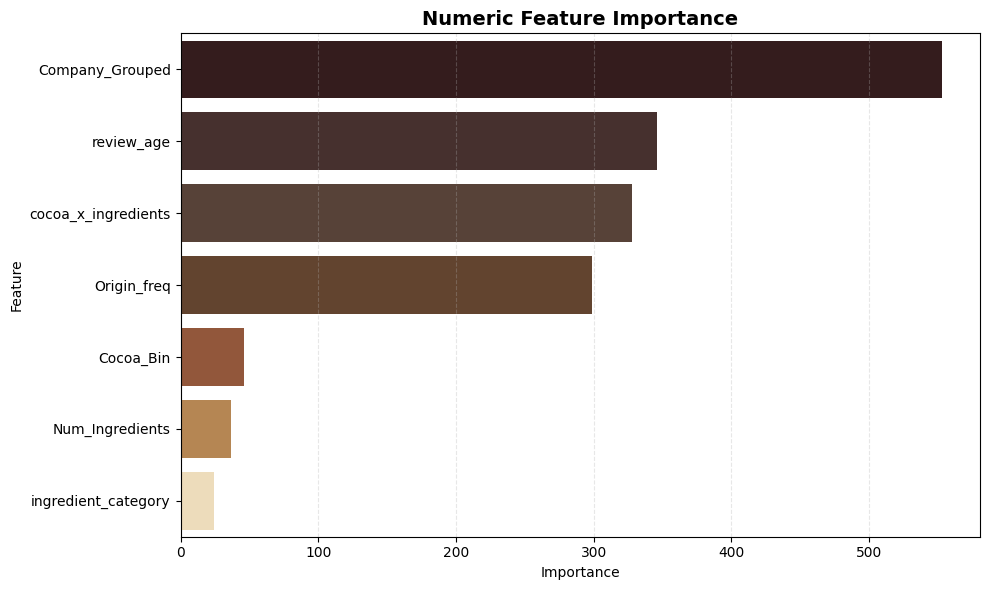

In [15]:
# 1. Get TF-IDF feature names from the fitted vectorizer
tfidf_features = tfidf.get_feature_names_out()

# 2. Get feature importances from model (LightGBM)
all_importances = model.booster_.feature_importance()

# 3. Separate numeric + TF-IDF importances
n_numeric = len(X_numeric.columns)
numeric_importances = all_importances[:n_numeric]
tfidf_importances = all_importances[n_numeric:]

# 4. DataFrame for numeric features
numeric_importances_df = pd.DataFrame({
    'Feature': X_numeric.columns,
    'Importance': numeric_importances
}).sort_values(by='Importance', ascending=False)

# 5. DataFrame for TF-IDF features
tfidf_importances_df = pd.DataFrame({
    'Feature': tfidf_features,
    'Importance': tfidf_importances
}).sort_values(by='Importance', ascending=False)

# 6. 🍫 Barplot of top 15 numeric features
choco_colors = [
    '#381819',  # Dark chocolate
    '#4a2c2a',  # Rich mocha
    '#5c4033',  # Bitter cocoa
    '#6b4226',  # Rustic brown
    '#a0522d',  # Milk chocolate
    '#c68642',  # Toffee
    '#f5deb3'   # White chocolate
]

plt.figure(figsize=(10, 6))
sns.barplot(
    x='Importance',
    y='Feature',
    data=numeric_importances_df.head(15),
    palette=choco_colors
)
plt.title('Numeric Feature Importance', fontsize=14, weight='bold')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.grid(axis='x', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()


## ☁️ TF-IDF Word Cloud

A word cloud was generated using the TF-IDF feature importances to highlight the most influential words and phrases from the "Most Memorable Characteristics" text. The size of each word reflects its importance in predicting chocolate ratings.


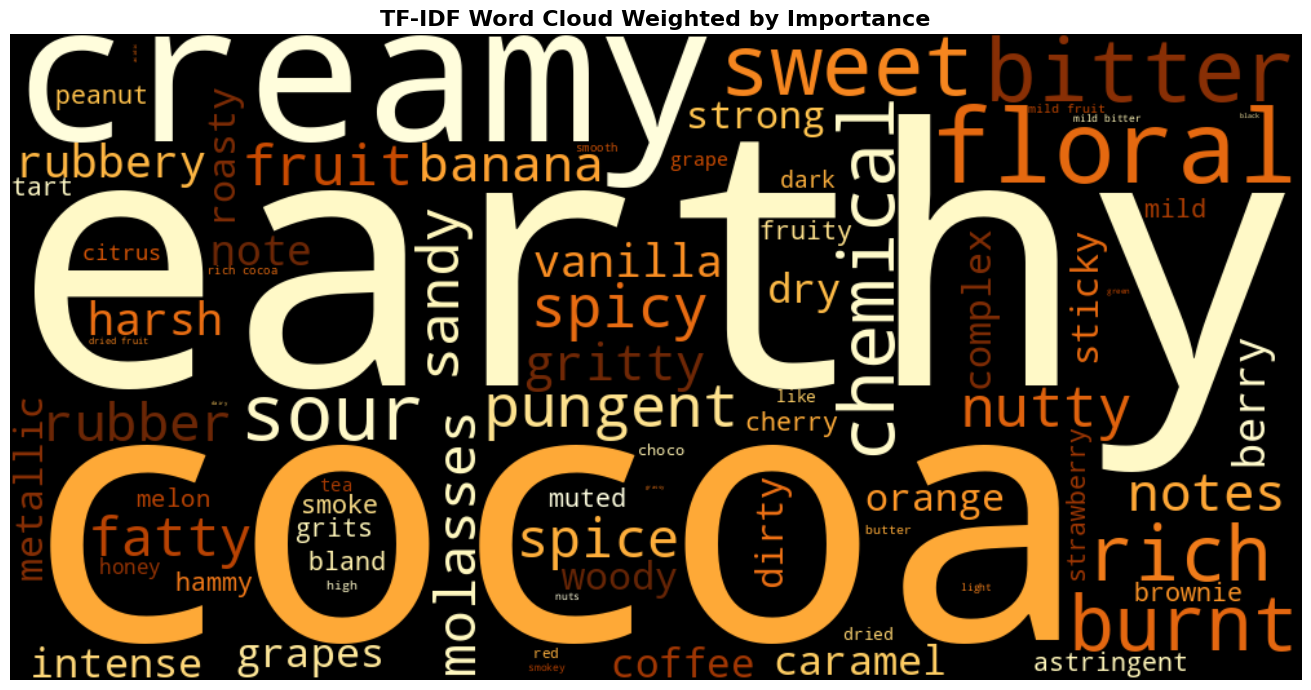

In [16]:
# 7. Word Cloud for TF-IDF feature importances
tfidf_dict = dict(zip(tfidf_importances_df['Feature'], tfidf_importances_df['Importance']))
wordcloud = WordCloud(
    width=1000,
    height=500,
    background_color='black',
    colormap='YlOrBr'
).generate_from_frequencies(tfidf_dict)

plt.figure(figsize=(14, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("TF-IDF Word Cloud Weighted by Importance", fontsize=16, weight='bold')
plt.tight_layout()
plt.show()

## 📌 Final Conclusion

This project aimed to predict chocolate bar ratings using a blend of structured attributes (like cocoa content, ingredients, and origin) and unstructured text data from reviews. Through extensive feature engineering and the integration of TF-IDF vectors from textual descriptions, we trained a LightGBM regression model that achieved an impressive **RMSE of 0.3507**.

Key insights from feature importance:
- `Company_Grouped` was by far the most influential feature, highlighting how manufacturer reputation significantly impacts ratings.
- `Origin_freq` (frequency of bean origin) and `review_age` also contributed strongly, suggesting regional and temporal influences.
- Other features like `cocoa_x_ingredients`, `Cocoa_Bin`, and `ingredient_category` offered additional predictive value.

The combination of text analysis and numerical attributes proved effective, emphasizing the value of hybrid features in flavor-centric domains like chocolate.

🍫 **Overall, this project demonstrates a data-driven approach to decoding what makes chocolate memorable and well-rated.**
